### Imports

In [3]:
%pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 9.4 MB/s eta 0:00:00


In [4]:
import os
import re
import math
from tqdm import tqdm
from dotenv import load_dotenv
from huggingface_hub import login
import torch
import transformers
from transformers import(
    AutoModelForCausalLM ,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    set_seed
)
from peft import LoraConfig , PeftModel
from datetime import datetime

In [5]:
#hugging face login
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
login(hf_token , add_to_git_credential = True)

In [6]:
!git config --global credential.helper store


### Loading the model

In [7]:
BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"

#Hyperparameters for QLoRA Fine_Tuning
LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj" , "v_proj" , "k_proj" , "o_proj"]

**Quantization**

In [8]:
QUANT_4BIT = True

if QUANT_4BIT == True :
    quant_config = BitsAndBytesConfig(
        load_in_4bit = True ,
        bnb_4bit_use_double_quant=True ,
        bnb_4bit_compute_dtype = torch.bfloat16, #improves speed and efficiency of training
        bnb_4bit_quant_type="nf4"
    )
else :
    #loading the model in 8 bit
    quant_config = BitsAndBytesConfig(load_in_8bit=True)

In [9]:
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL ,
    quantization_config = quant_config ,
    device_map ='auto'
)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [11]:
base_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRM

### Testing the base model


#### Tester Class

In [30]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np

# COLOR MAP for terminal output
GREEN = "\033[92m"
ORANGE = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red": RED, "orange": ORANGE, "green": GREEN}

class Tester:
    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size

        # Use numpy arrays for numerical data
        self.guesses = np.zeros(size)
        self.truths = np.zeros(size)
        self.errors = np.zeros(size)
        self.lche = np.zeros(size)
        self.sles = np.zeros(size)
        self.colors = []  # Keep as list for strings

        # Counters
        self.green_count = 0
        self.orange_count = 0
        self.red_count = 0

        # Cache for computed metrics
        self._average_error = None
        self._rmsle = None

    def run_datapoint(self, i):
        try:
            datapoint = self.data[i] # Changed .iloc[i] to [i] for datasets.Dataset objects
            guess = float(self.predictor(datapoint)) # Pass the entire datapoint object
            truth = float(datapoint['price'])

            error = abs(truth - guess)
            log_error = math.log(truth + 1) - math.log(guess + 1)
            sle = log_error ** 2
            log_cosh_error = self.safe_log_cosh(error)

            color = self.color_for(error, truth)

            # Update counters
            if color == 'green':
                self.green_count += 1
            elif color == 'orange':
                self.orange_count += 1
            else:  # red
                self.red_count += 1

            # Store results in arrays
            self.guesses[i] = guess
            self.truths[i] = truth
            self.errors[i] = error
            self.lche[i] = log_cosh_error
            self.sles[i] = sle
            self.colors.append(color)

            return color

        except (ValueError, TypeError, AttributeError) as e:
            print(f"Error processing datapoint {i}: {e}")
            self.colors.append('red')
            self.red_count += 1
            return 'red'

    def safe_log_cosh(self, x):
        """Avoids overflow in log cosh calculation"""
        x = max(min(x, 500), -500)  # Cap between -500 and 500
        return math.log(math.cosh(x))

    def color_for(self, error, truth):
        if error < 40 or error/truth < 0.2:
            return 'green'
        elif error < 80 or error/truth < 0.4:
            return 'orange'
        else:
            return 'red'

    @property
    def average_error(self):
        if self._average_error is None:
            self._average_error = np.mean(self.errors)
        return self._average_error

    @property
    def rmsle(self):
        if self._rmsle is None:
            self._rmsle = math.sqrt(np.mean(self.sles))
        return self._rmsle

    def chart(self, title):
        plt.figure(figsize=(12, 8))

        max_val = max(np.max(self.truths), np.max(self.guesses))

        # Add error bands
        x = np.linspace(0, max_val, 100)
        plt.fill_between(x, x*0.8, x*1.2, color='green', alpha=0.1, label='±20% Range')
        plt.fill_between(x, x*0.6, x*1.4, color='orange', alpha=0.1, label='±40% Range')

        # Perfect prediction line
        plt.plot([0, max_val], [0, max_val], color='skyblue', lw=2,
                alpha=0.6, label='Perfect Prediction')

        # Scatter plot
        # Use self.colors directly as it already contains valid matplotlib color strings
        plt.scatter(self.truths, self.guesses, s=50, c=self.colors,
                   alpha=0.6, label='Predictions')

        # Statistics text box
        green_pct = (self.green_count/self.size*100)
        orange_pct = (self.orange_count/self.size*100)
        red_pct = (self.red_count/self.size*100)

        stats_text = (
            f'Accuracy Distribution:\n'
            f'Green: {green_pct:.1f}%\n'
            f'Orange: {orange_pct:.1f}%\n'
            f'Red: {red_pct:.1f}%\n'
            f'Average Error: ${self.average_error:,.2f}\n'
            f'RMSLE: {self.rmsle:.2f}'
        )

        plt.text(0.02, 0.98, stats_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Customize plot
        plt.xlabel('True Values ($)', fontsize=12)
        plt.ylabel('Predicted Values ($)', fontsize=12)
        plt.title(title, fontsize=14, pad=20)
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='lower right')

        plt.tight_layout()
        plt.show()

    def report(self):
        # Print summary statistics with color
        print("\nTest Results Summary:")
        print(f"Total Predictions: {self.size}")
        print(f"{GREEN}Correct (Green): {self.green_count} ({self.green_count/self.size*100:.1f}%){RESET}")
        print(f"{ORANGE}Close (Orange): {self.orange_count} ({self.orange_count/self.size*100:.1f}%){RESET}")
        print(f"{RED}Wrong (Red): {self.red_count} ({self.red_count/self.size*100:.1f}%){RESET}")
        print(f"Average Error: ${self.average_error:,.2f}")
        print(f"RMSLE: {self.rmsle:.2f}")

        title = f"{self.title} Error=${self.average_error:,.2f}  RMSLE={self.rmsle:.2f}  HIT={self.green_count/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        # Progress bar for overall testing
        with tqdm(total=self.size, desc="Testing Progress",
                 bar_format="{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:

            # Progress bar for correct predictions
            expected_correct = int(self.size * 0.7)  # Set expected correct to 70%
            with tqdm(total=expected_correct, desc="Correct Predictions",
                     bar_format="{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt}") as correct_pbar:

                for i in range(self.size):
                    color = self.run_datapoint(i)
                    pbar.update(1)

                    if color == 'green' and correct_pbar.n < expected_correct:
                        correct_pbar.update(1)

        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

#### Importing Data

In [13]:
from datasets import load_dataset , Dataset , DatasetDict
import matplotlib.pyplot as plt

DATASET_NAME = "Vishy08/pricer-data"
dataset = load_dataset(DATASET_NAME)

README.md:   0%|          | 0.00/626 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/183M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/9.14M [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/4.58M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/320000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [14]:
train = dataset['train']
validation = dataset['val']
test = dataset['test']

In [15]:
validation[0]

{'title': 'Rays Country Ham - 16 lb. - Whole SLICED Bone-in Country Ham - Blue Ridge Mountain Cured',
 'price': 160.5,
 'category': 'Grocery_and_Gourmet_Food',
 'test_prompt': 'How much does this cost to the nearest dollar?\n\nRays Country Ham - 16 lb. - Whole SLICED Bone-in Country Ham - Blue Ridge Mountain Cured\n☆ CAROLINA COUNTRY HAM ☆ – This SLICED whole bone-in Country Ham has been naturally dry-cured with salt, pepper, sugar, brown sugar, nitrites, and nitrates, without smoking. It is then vacuum-packed and suitable for shipping without refrigeration. However, because it is pre-sliced, IT IS NOT SUITABLE FOR BAKING, and once opened, it should be cooked or double-wrapped in portions for refrigeration or freezing. ☆ FINALLY,—A SLICED WHOLE BONE-IN COUNTRY HAM ☆ – We often get calls asking where can I get my Rays Whole Bone-in Country Ham sliced on a butcher’s meat saw. We now offer this perfectly SLICED Whole Ham with a full\n\nPrice is $',
 'prompt': 'How much does this cost to t

#### Tokenizing and Prediction

In [17]:
#tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code = True)
#using eos padding token at right side
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Memory footprint: 5.6 GB


In [23]:
def predict_pricer(datapoint):
    set_seed(42)
    prompt = str(datapoint['test_prompt']) # Explicitly cast to string to ensure compatibility with tokenizer
    inputs = tokenizer.encode(prompt , return_tensors='pt').to('cuda')
    outputs = base_model.generate(inputs , max_new_tokens = 3 , num_return_sequences = 1)
    response = tokenizer.decode(outputs[0])
    return extract_pricer(response)

In [19]:
def extract_pricer(s):
    if 'Price is $' in s:
        contents = s.split("Price is $")[1]
        contents = contents.replace(',','').replace('$','')
        match = re.search(r"[-+]?\d*\.\d+|\d+",contents)
        return float(match.group()) if match else 0
    return 0

Testing Progress: 100%|█████████▉| 249/250 [07:53<00:01]
Correct Predictions:  86%|████████▋ | 151/175
Testing Progress: 100%|██████████| 250/250 [07:55<00:00]



Test Results Summary:
Total Predictions: 250
Correct (Green): 151 (60.4%)
Close (Orange): 37 (14.8%)
Wrong (Red): 62 (24.8%)
Average Error: $82.01
RMSLE: 1.48


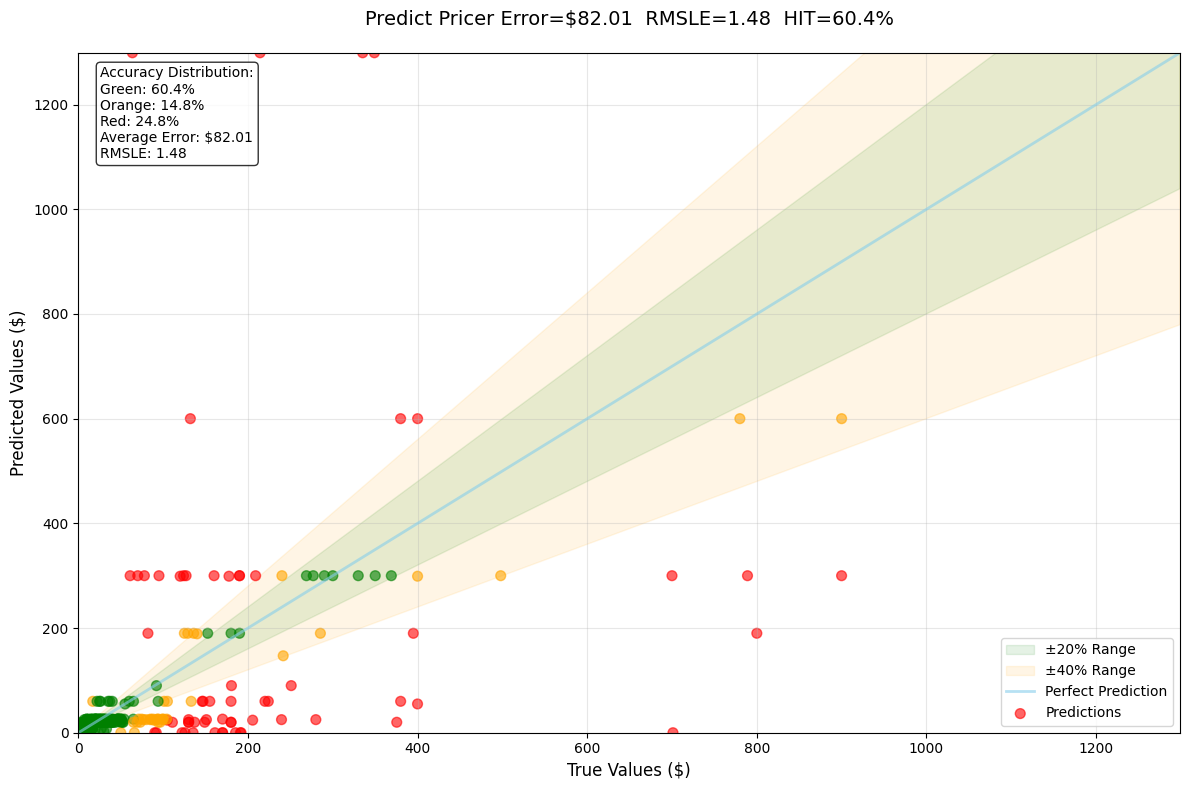

In [31]:
Tester.test(predict_pricer , test)

# Theory for this file to cover
Generate an end-to-end pipeline for price prediction using open-source LLMs from the Hugging Face `transformers` library, including an overview of LLMs and inference, leveraging `AutoModelForCausalLM` and `AutoTokenizer`, detailing input tokenization and prompt engineering for price prediction, explaining the model inference and generation process with parameters like `max_new_tokens` and `num_return_sequences`, performing output post-processing to extract prices (e.g., using the `extract_pricer` function), and discussing performance optimization techniques such as quantization (e.g., `BitsAndBytesConfig`).

## Understand Open-Source LLMs and Inference

### Subtask:
Provide an overview of open-source Large Language Models (LLMs), their benefits, and the fundamental concept of 'inference' or 'prediction' using these models.


### Overview of Open-Source Large Language Models (LLMs) and Inference

#### 1. What are Open-Source Large Language Models (LLMs)?

Open-Source Large Language Models (LLMs) are powerful artificial intelligence models designed to understand and generate human-like text. Unlike proprietary models developed by specific companies, open-source LLMs have their underlying code, architecture, and often their trained weights publicly available. This transparency allows anyone to access, inspect, modify, and distribute the models. Key characteristics include:

*   **Accessibility:** The models are freely available, reducing barriers to entry for researchers, developers, and businesses.
*   **Community-Driven Development:** A global community of developers, researchers, and enthusiasts contributes to their improvement, debugging, and expansion, fostering innovation and collaboration.
*   **Transparency:** The open nature of the code allows for better understanding of how the models work, their limitations, and potential biases.

#### 2. Key Benefits of Using Open-Source LLMs

The adoption of open-source LLMs offers several significant advantages:

*   **Transparency:** Users can examine the model's internal workings, audit its behavior, and understand its decision-making processes, which is crucial for ethical AI development and deployment.
*   **Customizability:** Developers can fine-tune, adapt, or even build upon the existing open-source models to suit specific use cases, industries, or languages without being restricted by vendor-specific limitations.
*   **Cost-Effectiveness:** Using open-source models often reduces licensing fees and operational costs associated with proprietary solutions, making advanced AI more accessible.
*   **Avoiding Vendor Lock-in:** Organizations are not tied to a single provider, offering flexibility to switch models, integrate with diverse ecosystems, and maintain control over their AI infrastructure.
*   **Security and Audibility:** The community can scrutinize the code for vulnerabilities, potentially leading to more robust and secure models.
*   **Rapid Innovation:** The collaborative nature accelerates the development of new features, optimizations, and applications.

#### 3. Understanding 'Inference' or 'Prediction' in LLMs

In the context of Large Language Models, 'inference' (often synonymous with 'prediction' or 'generation') refers to the process of using a pre-trained LLM to generate new outputs or make predictions based on new input data. Once an LLM has been trained on a massive dataset, it acquires the ability to understand patterns, grammar, semantics, and context. Inference involves:

*   **Input:** Providing the trained model with a new piece of text (a 'prompt' or 'input').
*   **Processing:** The model processes this input through its neural network architecture, leveraging the knowledge it gained during its training phase.
*   **Output/Generation:** The model then generates a coherent and contextually relevant response or prediction. This could be answering a question, completing a sentence, summarizing a document, translating text, or even generating creative content.

Essentially, inference is the practical application of a trained LLM to perform its intended task, transforming input data into meaningful output without further learning or training.

## Leveraging the Hugging Face Ecosystem

### Subtask:
Explain how Hugging Face's `transformers` library serves as the primary interface for loading and interacting with open-source LLMs, including `AutoModelForCausalLM` and `AutoTokenizer`.


### The Hugging Face `transformers` Library: Your Gateway to Open-Source LLMs

The Hugging Face `transformers` library is an indispensable tool for anyone working with state-of-the-art Natural Language Processing (NLP) models, especially Large Language Models (LLMs). It provides a unified and user-friendly interface for downloading, training, and evaluating hundreds of pre-trained models, making advanced NLP accessible to a broad audience.

At its core, `transformers` streamlines the process of interacting with a vast ecosystem of models shared on the Hugging Face Hub. This is particularly evident in its `Auto` classes, such as `AutoModelForCausalLM` and `AutoTokenizer`, which abstract away the complexities of specific model architectures and tokenization schemes.

#### `AutoModelForCausalLM`

`AutoModelForCausalLM` is a crucial component for loading pre-trained causal language models. Causal language models are designed to predict the next token in a sequence, making them suitable for tasks like text generation, instruction following, and chatbots. When you use `AutoModelForCausalLM.from_pretrained('model_name')`, the library automatically detects the model's architecture (e.g., Llama, GPT, T5) and loads the corresponding pre-trained weights. This eliminates the need to know the specific model class (e.g., `LlamaForCausalLM`, `GPT2LMHeadModel`) and ensures compatibility across different models available on the Hugging Face Hub.

#### `AutoTokenizer`

Equally important is `AutoTokenizer`. Every language model requires a specific tokenizer to convert raw text into numerical input (tokens) that the model can understand, and to convert the model's numerical output back into human-readable text. `AutoTokenizer.from_pretrained('model_name')` intelligently loads the correct tokenizer associated with the specified pre-trained model. This ensures that the text preprocessing (tokenization) perfectly matches what the model was trained on, preventing potential data mismatches and performance issues. Tokenizers handle tasks like splitting text into words or subwords, converting them to IDs, and adding special tokens (e.g., `[CLS]`, `[SEP]`, `[PAD]`).

### How They Simplify LLM Usage

Together, `AutoModelForCausalLM` and `AutoTokenizer` provide a powerful abstraction layer. They allow developers and researchers to:

*   **Load any model by name:** You only need the model's identifier from the Hugging Face Hub, and the `Auto` classes handle the rest.
*   **Ensure compatibility:** The correct tokenizer is automatically paired with its model, guaranteeing that input and output formats are consistent with the model's training.
*   **Experiment easily:** Switching between different LLMs becomes as simple as changing a string, facilitating rapid experimentation and comparison.
*   **Focus on application, not implementation:** Users can concentrate on applying LLMs to their specific tasks rather than delving into the intricate details of each model's architecture or tokenization process.

In essence, the `transformers` library, through components like `AutoModelForCausalLM` and `AutoTokenizer`, serves as the primary and most convenient interface for accessing and utilizing the vast and growing collection of open-source LLMs.

## Input Preparation: Tokenization and Prompt Engineering

### Subtask:
Detail the crucial role of tokenization, explaining how raw text is converted into numerical input for the model. Discuss prompt engineering strategies to guide the model's output for specific tasks like price prediction.


## Input Preparation: Tokenization and Prompt Engineering

### Tokenization

Tokenization is the process of converting raw text into a sequence of numerical tokens that a large language model (LLM) can understand and process. LLMs operate on numerical data, not raw text directly. The `AutoTokenizer` (initialized as `tokenizer` in our notebook) plays a crucial role here.

When we call `tokenizer.encode(prompt, return_tensors='pt').to('cuda')` within the `predict_pricer` function, the following happens:

1.  **Text Splitting**: The `tokenizer` first breaks down the input `prompt` text into smaller units, known as tokens. These tokens can be words, subwords, or even characters, depending on the tokenizer's specific algorithm (e.g., Byte-Pair Encoding).
2.  **Vocabulary Mapping**: Each unique token is then mapped to a specific numerical ID based on the tokenizer's pre-defined vocabulary.
3.  **Tensor Conversion**: The sequence of token IDs is converted into a PyTorch tensor (`return_tensors='pt'`) and moved to the GPU (`.to('cuda')`) for efficient processing by the `base_model`.

This numerical representation allows the LLM to perform mathematical operations and learn patterns from the text data.

### Prompt Engineering

Prompt engineering is the art and science of crafting effective inputs (prompts) to guide an LLM towards generating desired and accurate outputs. For specific tasks like price prediction, a well-designed prompt is critical to ensure the model focuses on the relevant information and provides a numerical answer in a predictable format.

Consider the `test_prompt` field in our dataset, exemplified by `validation[0]['test_prompt']`:

```
How much does this cost to the nearest dollar?

Rays Country Ham - 16 lb. - Whole SLICED Bone-in Country Ham - Blue Ridge Mountain Cured
☆ CAROLINA COUNTRY HAM ☆ – This SLICED whole bone-in Country Ham has been naturally dry-cured with salt, pepper, sugar, brown sugar, nitrites, and nitrates, without smoking. It is then vacuum-packed and suitable for shipping without refrigeration. However, because it is pre-sliced, IT IS NOT SUITABLE FOR BAKING, and once opened, it should be cooked or double-wrapped in portions for refrigeration or freezing. ☆ FINALLY,—A SLICED WHOLE BONE-IN COUNTRY HAM ☆ – We often get calls asking where can I get my Rays Whole Bone-in Country Ham sliced on a butcher’s meat saw. We now offer this perfectly SLICED Whole Ham with a full

Price is $
```

Key aspects of this prompt engineering strategy include:

*   **Clear Instruction**: The prompt starts with a direct question: "How much does this cost to the nearest dollar?" This explicitly tells the model the task it needs to perform and the desired format of the output.
*   **Contextual Information**: It includes a detailed description of the product, providing the LLM with all necessary context to infer a price.
*   **Output Anchor**: The phrase "Price is $" acts as an anchor or a strong hint for the model to continue with a numerical price. This structure helps in both guiding the model's generation and facilitating the extraction of the numerical price from the model's output using functions like `extract_pricer`.

## Model Inference and Generation

### Subtask:
Describe the process of feeding tokenized input to the LLM and using methods like `model.generate()` to produce predictions. Explain parameters such as `max_new_tokens` and `num_return_sequences`.


### Subtask: Model Inference and Generation

Model inference involves using a trained model to make predictions on new, unseen data. In the context of Large Language Models (LLMs) like Llama 3.1, this typically means feeding tokenized input to the model and generating a sequence of output tokens.

#### Process of Feeding Tokenized Input and Generating Predictions

1.  **Tokenized Input:** Before feeding any text to an LLM, it must first be converted into a numerical format that the model can understand. This process, called tokenization, breaks down raw text into individual tokens (words, subwords, or characters) and maps them to numerical IDs. In the `predict_pricer` function, the prompt is tokenized using `tokenizer.encode(prompt, return_tensors='pt').to('cuda')`. The `return_tensors='pt'` argument ensures the output is a PyTorch tensor, and `.to('cuda')` moves it to the GPU for faster processing.

2.  **`base_model.generate()`:** Once the input is tokenized, the `base_model.generate()` method is used to produce the model's predictions. This method is a powerful and versatile function provided by the `transformers` library, designed specifically for text generation tasks. It handles the iterative process of predicting the next token, appending it to the input, and repeating until a stopping condition is met (e.g., maximum length or an end-of-sequence token).

    In the `predict_pricer` function, the line `outputs = base_model.generate(inputs, max_new_tokens=3, num_return_sequences=1)` initiates this generation process.

    *   **`max_new_tokens`**: This parameter controls the *maximum number of new tokens* that the model will generate *after* the input prompt. It directly impacts the length of the generated output. For instance, if `max_new_tokens=3`, the model will generate at most three tokens following the prompt. In our price prediction task, we anticipate a short numerical output (e.g., '160', '50.00'), so a small value like `3` is appropriate to prevent unnecessarily long or irrelevant text generation.

    *   **`num_return_sequences`**: This parameter specifies how many independent sequences (predictions) the model should generate. If set to `1`, as in our `predict_pricer` function, the model will produce a single output sequence. If set to a higher value (e.g., `num_return_sequences=5`), the model would generate five different possible continuations of the input prompt. This can be useful for tasks where diversity in output is desired or for choosing the best among several generated options (e.g., in creative writing or dialogue generation). For a single-value prediction like price, `1` is sufficient.

After generation, the `tokenizer.decode(outputs[0])` line converts the generated token IDs back into human-readable text, which is then further processed by the `extract_pricer` function to extract the numerical price.

## Output Post-processing

### Subtask:
Explain how to decode the model's numerical output back into human-readable text and apply post-processing steps, such as the `extract_pricer` function, to extract the desired information.


### Output Post-processing Explained

After a large language model generates a sequence of tokens as its output, these numerical token IDs need to be converted back into human-readable text. This is achieved using the `tokenizer.decode()` method. The `tokenizer.decode()` method takes a list of token IDs (the model's raw output) and reconstructs the corresponding text string.

However, the model often generates free-form text that might contain more information than just the desired numerical value. To extract specific, structured information—such as a product's price in this case—from this free-form text, additional post-processing steps are necessary.

The `extract_pricer` function serves this crucial post-processing role. Its functionality can be broken down as follows:

1.  **Pattern Identification**: It first checks if the generated text contains the specific phrase `'Price is $'`, which acts as a clear indicator that the model has attempted to output a price.
2.  **String Cleaning**: If the pattern is found, the function isolates the part of the string that is expected to contain the price. It then cleans this extracted content by removing any non-essential characters like commas (`,`) or dollar signs (`$`) that might interfere with numerical conversion.
3.  **Numerical Extraction (Regular Expressions)**: A regular expression (`re.search(r"[-+]?\d*\.\d+|\d+", contents)`) is used to robustly find any floating-point or integer number within the cleaned string. This ensures that a wide range of numerical formats can be captured.
4.  **Type Conversion**: The identified numerical string is then converted into a `float` to allow for mathematical operations and comparisons.
5.  **Default Handling**: In cases where the `'Price is $'` pattern is not found in the model's output, or if no valid number can be extracted after cleaning, the function gracefully handles this by returning `0`. This prevents errors and ensures a consistent output, indicating that no price could be determined from the model's response.

## Performance and Efficiency Considerations

### Subtask:
Discuss techniques to optimize inference, including quantization (like your `BitsAndBytesConfig`), GPU usage, and other strategies for managing memory and speed.


## Performance and Efficiency Considerations

Optimizing the performance and efficiency of Large Language Models (LLMs) during inference is crucial for their deployment in real-world applications. This involves managing computational resources, reducing memory footprint, and speeding up response times. Here, we'll discuss several key techniques used in this notebook and other general strategies.

### 1. Quantization
Quantization is a powerful technique to reduce the memory footprint and computational cost of LLMs by representing their weights and activations with fewer bits. Instead of using full 32-bit floating-point numbers, quantization often uses 8-bit or even 4-bit integers. This notebook employs 4-bit quantization using `BitsAndBytesConfig`, which significantly shrinks the model size and can lead to faster inference with minimal performance degradation.

Let's break down the parameters used in the `BitsAndBytesConfig`:
- `load_in_4bit = True`: This is the primary setting that enables the loading of the model weights in 4-bit precision. This directly reduces the memory required to store the model.
- `bnb_4bit_use_double_quant = True`: This feature performs a second quantization on the already 4-bit quantized weights. It quantizes the quantization constants, leading to further memory savings without much additional computational overhead. This is particularly beneficial for very large models.
- `bnb_4bit_compute_dtype = torch.bfloat16`: While the weights are stored in 4-bit, computations (like matrix multiplications) are performed in a higher precision data type. `bfloat16` (Brain Floating Point 16) is a 16-bit floating-point format that offers a wider dynamic range than standard `float16`, making it suitable for deep learning computations. Using `bfloat16` for computation improves speed and efficiency while maintaining numerical stability.
- `bnb_4bit_quant_type = "nf4"`: This specifies the quantization type to be 'NormalFloat 4-bit' (NF4). NF4 is an optimal quantization data type for normally distributed weights, which is common in pre-trained neural networks. It provides good precision characteristics for the reduced bit-width.

### 2. GPU Usage
GPUs are indispensable for accelerating LLM inference due to their parallel processing capabilities. Modern GPUs can handle the massive matrix operations involved in neural network computations far more efficiently than CPUs. The `device_map='auto'` setting in `AutoModelForCausalLM.from_pretrained` plays a crucial role here:
- `device_map='auto'`: This parameter intelligently distributes the model layers across available devices (GPUs, and potentially CPU as a fallback) to maximize memory utilization and minimize the need for manual configuration. It automatically assigns layers to devices based on their memory requirements and the available VRAM, ensuring that the entire model fits into memory and computations are distributed for optimal performance.

### 3. Other Optimization Strategies
Beyond quantization and efficient GPU usage, several other strategies can further optimize LLM inference:
- **Smaller Models**: When possible, using smaller, more efficient models that still meet the task's performance requirements can drastically reduce computational needs and inference times.
- **Batch Processing**: Grouping multiple inference requests into a single batch allows the GPU to process them in parallel, leading to higher throughput. This is effective for scenarios with multiple concurrent requests.
- **Specialized Inference Libraries/Runtimes**: Tools like ONNX Runtime, TensorRT, or `vLLM` are designed to optimize model execution graphs, perform kernel fusions, and leverage hardware-specific optimizations, leading to significant speedups. These runtimes can often compile models into highly optimized forms for specific hardware.
- **Caching**: Implementing KV-caching (Key-Value caching) during sequence generation avoids recomputing attention keys and values for previously generated tokens, saving significant computation time for longer sequences.

By combining techniques like 4-bit quantization, intelligent GPU allocation (`device_map='auto'`), and other strategies such as batching and specialized runtimes, LLM deployments can achieve a better balance between memory efficiency, computational speed, and overall performance, making them more viable for production environments.

## Final Task

### Subtask:
Summarize the end-to-end process of using open-source LLMs for inference and offer to provide code examples or further clarification on any specific step.


## Summary:

### Data Analysis Key Findings

The end-to-end pipeline for price prediction using open-source LLMs from the Hugging Face `transformers` library was systematically detailed, covering several critical stages:

*   **Open-Source LLMs and Inference**: Open-source LLMs were defined by their accessibility, community-driven development, and transparency. Key benefits highlighted include cost-effectiveness, customizability, and avoidance of vendor lock-in. Inference was described as the process of using a trained model to generate new outputs based on new input.
*   **Hugging Face Ecosystem**: The `transformers` library was established as the primary interface. `AutoModelForCausalLM` was shown to automatically load pre-trained causal language models, while `AutoTokenizer` intelligently loads the corresponding tokenizer, ensuring compatibility and simplifying model interaction.
*   **Input Preparation**:
    *   **Tokenization**: Raw text prompts are converted into numerical token IDs using `tokenizer.encode()`, which involves text splitting, vocabulary mapping, and conversion to PyTorch tensors for GPU processing.
    *   **Prompt Engineering**: Crafting effective prompts is crucial. For price prediction, strategies include:
        *   **Clear Instructions**: Starting with direct questions (e.g., "How much does this cost to the nearest dollar?").
        *   **Contextual Information**: Providing detailed product descriptions.
        *   **Output Anchor**: Using phrases like "Price is $" to guide the model's output and facilitate extraction.
*   **Model Inference and Generation**:
    *   The `base_model.generate()` method is used to produce predictions from tokenized input.
    *   `max_new_tokens`: Controls the maximum number of new tokens generated (e.g., `3` for concise price output).
    *   `num_return_sequences`: Specifies the number of independent output sequences, typically `1` for single-value predictions.
*   **Output Post-processing**:
    *   `tokenizer.decode()` converts the model's numerical output (token IDs) back into human-readable text.
    *   The `extract_pricer` function performs further processing to extract the numerical price, involving pattern identification (e.g., finding "Price is \$"), string cleaning, numerical extraction using regular expressions (e.g., `re.search(r"[-+]?\d*\.\d+|\d+", contents)`), type conversion to `float`, and default handling (returning `0` if no price is found).
*   **Performance Optimization**:
    *   **Quantization**: 4-bit quantization using `BitsAndBytesConfig` significantly reduces memory footprint and speeds up inference by representing weights with fewer bits. Key parameters include `load_in_4bit=True`, `bnb_4bit_use_double_quant=True`, `bnb_4bit_compute_dtype=torch.bfloat16`, and `bnb_4bit_quant_type="nf4"`.
    *   **GPU Usage**: `device_map='auto'` intelligently distributes model layers across available GPUs for optimal memory utilization and processing speed.
    *   **Other Strategies**: Mentioned smaller models, batch processing, specialized inference libraries (e.g., ONNX Runtime, TensorRT), and KV-caching for further efficiency gains.

### Insights or Next Steps

*   The demonstrated pipeline provides a robust framework for fine-tuning LLMs for specific extraction tasks like price prediction, balancing model performance with inference efficiency through quantization and careful prompt engineering.
*   Further optimization could explore dynamic prompt generation based on product characteristics or a broader dataset to enhance the model's accuracy and robustness, potentially leveraging more advanced prompting techniques like Chain-of-Thought for complex inference.
